# TP2 : La Segmentation bayésienne d’image

## I) La segmentation bayésienne d’image

In [24]:
import numpy as np
import scipy as scp
import sklearn
import cv2 as cv

from math import log2, sqrt
from scipy.stats import norm
from sklearn.cluster import KMeans

import os

from matplotlib import pyplot as plt

## II) Modèle des couples indépendants

In [25]:
def get_line_index(dSize):
    """
    Cette fonction permet d'obtenir l'ordre de parcours des pixels d'une image carrée selon un parcours ligne par ligne
    :param dSize: largeur ou longueur de l'image en pixel (peu importe, la fonction ne fonctionne qu'avec des images carrées)
    :return: une liste de taille 2*dSize*dSize qui correspond aux coordonnées de chaque pixel ordonnée selon le parcours ligne par ligne
    """
    return [a.flatten() for a in np.indices((dSize, dSize))]


def line_transform_img(img):
    """
    Cette fonction prend une image carrée en entrée, et retourne l'image applatie (1 dimension) selon le parcours ligne par ligne
    :param img: une image (donc un numpy array 2 dimensions)
    :return: un numpy array 1 dimension
    """
    assert img.shape[0] == img.shape[1], 'veuillez donner une image carrée en entrée'
    idx = get_line_index(img.shape[0])
    return img[idx[0], idx[1]]


def transform_line_in_img(signal, dSize):
    """
    Cette fonction prend un signal 1D en entrée et une taille, et le transforme en image carrée 2D selon le parcours ligne par ligne
    :param img: un signal 1D
    :param dSize: largeur ou longueur de l'image en pixel (peu importe, la fonction de fonctionne qu'avec des images carrées)
    :return: une image (donc un numpy array 2 dimensions)
    """
    assert dSize == int(sqrt(signal.shape[0])), 'veuillez donner un signal ayant pour dimension dSize^2'
    idx = get_line_index(dSize)
    img = np.zeros((dSize, dSize))
    img[idx[0], idx[1]] = signal
    return img


def get_peano_index(dSize):
    """
    Cette fonction permet d'obtenir l'ordre de parcours des pixels d'une image carrée (dont la dimension est une puissance de 2)
    selon la courbe de Hilbert-Peano
    :param dSize: largeur ou longueur de l'image en pixel (peu importe, la fonction de fonctionne qu'avec des images carrées)
    :return: une liste de taille 2*dSize*dSize qui correspond aux coordonnées de chaque pixel ordonnée selon le parcours de Hilbert-Peano
    """
    assert log2(dSize).is_integer(), 'veuillez donne une dimension étant une puissance de 2'
    xTmp = 0
    yTmp = 0
    dirTmp = 0
    dirLookup = np.array(
        [[3, 0, 0, 1], [0, 1, 1, 2], [1, 2, 2, 3], [2, 3, 3, 0], [1, 0, 0, 3], [2, 1, 1, 0], [3, 2, 2, 1],
         [0, 3, 3, 2]]).T
    dirLookup = dirLookup + np.array(
        [[4, 0, 0, 4], [4, 0, 0, 4], [4, 0, 0, 4], [4, 0, 0, 4], [0, 4, 4, 0], [0, 4, 4, 0], [0, 4, 4, 0],
         [0, 4, 4, 0]]).T
    orderLookup = np.array(
        [[0, 2, 3, 1], [1, 0, 2, 3], [3, 1, 0, 2], [2, 3, 1, 0], [1, 3, 2, 0], [3, 2, 0, 1], [2, 0, 1, 3],
         [0, 1, 3, 2]]).T
    offsetLookup = np.array([[1, 1, 0, 0], [1, 0, 1, 0]])
    for i in range(int(log2(dSize))):
        xTmp = np.array([(xTmp - 1) * 2 + offsetLookup[0, orderLookup[0, dirTmp]] + 1,
                         (xTmp - 1) * 2 + offsetLookup[0, orderLookup[1, dirTmp]] + 1,
                         (xTmp - 1) * 2 + offsetLookup[0, orderLookup[2, dirTmp]] + 1,
                         (xTmp - 1) * 2 + offsetLookup[0, orderLookup[3, dirTmp]] + 1])

        yTmp = np.array([(yTmp - 1) * 2 + offsetLookup[1, orderLookup[0, dirTmp]] + 1,
                         (yTmp - 1) * 2 + offsetLookup[1, orderLookup[1, dirTmp]] + 1,
                         (yTmp - 1) * 2 + offsetLookup[1, orderLookup[2, dirTmp]] + 1,
                         (yTmp - 1) * 2 + offsetLookup[1, orderLookup[3, dirTmp]] + 1])

        dirTmp = np.array([dirLookup[0, dirTmp], dirLookup[1, dirTmp], dirLookup[2, dirTmp], dirLookup[3, dirTmp]])

        xTmp = xTmp.T.flatten()
        yTmp = yTmp.T.flatten()
        dirTmp = dirTmp.flatten()

    x = - xTmp
    y = - yTmp
    return x, y


def peano_transform_img(img):
    """
    Cette fonction prend une image carrée (dont la dimension est une puissance de 2) en entrée,
    et retourne l'image applatie (1 dimension) selon le parcours de Hilbert-Peano
    :param img: une image (donc un numpy array 2 dimensions)
    :return: un numpy array 1 dimension
    """
    assert img.shape[0] == img.shape[1], 'veuillez donner une image carrée en entrée'
    assert log2(img.shape[0]).is_integer(), 'veuillez donne rune image dont la dimension est une puissance de 2'
    idx = get_peano_index(img.shape[0])
    return img[idx[0], idx[1]]


def transform_peano_in_img(signal, dSize):
    """
    Cette fonction prend un signal 1D en entrée et une taille, et le transforme en image carrée 2D selon le parcours de Hilbert-Peano
    :param img: un signal 1D
    :param dSize: largeur ou longueur de l'image en pixel (peu importe, la fonction de fonctionne qu'avec des images carrées)
    :return: une image (donc un numpy array 2 dimensions)
    """
    assert dSize == int(sqrt(signal.shape[0])), 'veuillez donner un signal ayant pour dimension dSize^2'
    idx = get_peano_index(dSize)
    img = np.zeros((dSize, dSize))
    img[idx[0], idx[1]] = signal
    return img


def bruit_gauss2(X,cl1,cl2,m1,sig1,m2,sig2):
    return (X == cl1) * np.random.normal(m1, sig1, X.shape) + (X == cl2) * np.random.normal(m2, sig2, X.shape)


def MAP_MPM2(Y,cl1,cl2,p1,p2,m1,sig1,m2,sig2):
    return np.where((p1*norm.pdf(Y, m1, sig1)) > (p2*norm.pdf(Y, m2, sig2)), cl1, cl2)


def calc_probaprio2(X,cl1,cl2):
    return np.sum(X==cl1)/X.size, np.sum(X==cl2)/X.size


def taux_erreur(A,B):
    return np.sum((A-B)!=0)/A.size

### 3. estim_param_EM_indep(iter, Y, p1, p2, m1, sig1, m2, sig2)

In [26]:
def estim_param_EM_indep(K, Y, p1, p2, m1, sig1, m2, sig2):
    
    for k in range(K):
        px1 = (p1 * norm.pdf(Y, m1, sig1))/((p1 * norm.pdf(Y, m1, sig1)) + (p2 * norm.pdf(Y, m2, sig2)))
        px2 = 1 - px1
        p1 = (1/Y.size) * np.sum(px1)
        p2 = 1 - p1
        m1 = np.sum(px1 * Y)/np.sum(px1)
        m2 = np.sum(px2 * Y)/np.sum(px2)
        sig1 = np.sqrt(np.sum(((Y-m1)**2)*px1)/np.sum(px1))
        sig2 = np.sqrt(np.sum(((Y-m2)**2)*px2)/np.sum(px2))
        
    
    return p1, p2, m1, sig1, m2, sig2

### 4. Ecrire le script Segmentation_image_indep.py

11.345832880875786
1
theta0 : p1 = 0.4159088134765625 p2 = 0.5840911865234375 m10 = 4.115514161294793 m20 = 0.29031632902612164 sig10 = 1.3656438368502342 sig20 = 1.087323963610222
theta : p1 = 0.6132981844661893 p2 = 0.38670181553381067 m1 = 3.0610067488248682 sig1 = 1.985683658139126 m2 = 0.010188571418058633 sig2 = 1.0109144832059767 
Inversion des classes de l'image segmentée afin de correspondre à l'originale
erreur = 0.15814208984375
0.6132981844661893 0.38670181553381067
0 255
0 1


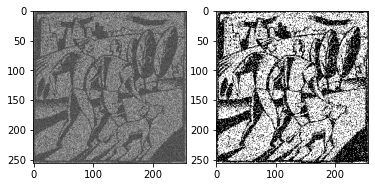

In [107]:
pathimg = 'images/promenade2.bmp'
#pathimg = 'images/beee2.bmp'

K = 300

m1, m2, sig1, sig2 = 0, 3, 1, 2



Ximg = cv.cvtColor(cv.imread(pathimg), cv.COLOR_BGR2GRAY)
Xlin = line_transform_img(Ximg)

cl1X, cl2X = np.unique(Ximg)


Y = bruit_gauss2(Xlin,cl1X,cl2X,m1,sig1,m2,sig2)

kmeans = KMeans(n_clusters=2, random_state=0).fit(Y.reshape(-1,1))

Yfit = kmeans.labels_

print(f'{max(Y)}')
print(f'{max(Yfit)}')

cl1, cl2 = np.unique(Yfit)


p1, p2 = calc_probaprio2(Yfit,cl1,cl2)

m10 = np.mean(Y[Yfit==cl1])
m20 = np.mean(Y[Yfit==cl2])
sig10 = np.std(Y[Yfit==cl1])
sig20 = np.std(Y[Yfit==cl2])

print(f'theta0 : p1 = {p1} p2 = {p2} m10 = {m10} m20 = {m20} sig10 = {sig10} sig20 = {sig20}')

p1, p2, m1, sig1, m2, sig2 = estim_param_EM_indep(K, Y, p1, p2, m10, sig10, m20, sig20)


print(f'theta : p1 = {p1} p2 = {p2} m1 = {m1} sig1 = {sig1} m2 = {m2} sig2 = {sig2} ')


S = MAP_MPM2(Y,cl1X,cl2X,p1,p2,m1,sig1,m2,sig2)

Yimg = transform_line_in_img(Y, 256)
Image = transform_line_in_img(S, 256)

err_inter = taux_erreur(Ximg,Image)

if err_inter >= 0.5:
    print('Inversion des classes de l\'image segmentée afin de correspondre à l\'originale')
    Image_fin = np.empty(Image.shape)
    Image_fin[Image == cl1X] = cl2X
    Image_fin[Image == cl2X] = cl1X
else:
    Image_fin = Image
    
err = taux_erreur(Ximg,Image_fin)

print(f'erreur = {err}')
print(f'{p1} {p2}')
print(f'{cl1X} {cl2X}')
print(f'{cl1} {cl2}')

plt.figure(1)
plt.subplot(121)
plt.imshow(Yimg,cmap='gray', vmin=np.min(Yimg), vmax=np.max(Yimg))
plt.subplot(122)
plt.imshow(Image_fin,cmap='gray', vmin=0, vmax=255);

### 5) Tester la méthode pour 3 images sélectionnées et 3 bruits

Les image sélectionnées sont : beee2, promenade2 et zebre2.
On va leur appliquer différents bruits, avec ces paramètres :

|m1|m2|sig1|sig2|
|:-:|:-:|:-:|:-:|
|0|3|1|2|
|1|1|1|5|
|0|1|1|1|

In [28]:
list_img = ['beee2','promenade2','zebre2']
list_bruits = [(0,3,1,2), (1,1,1,5), (0,1,1,1)]


Ximg = cv.cvtColor(cv.imread('images/'+pathimg+'.bmp'), cv.COLOR_BGR2GRAY)





## III) Modèle de chaîne de Markov cachées

### 1) Construire une matrice Mat_f destinée à simplifier les calculs des probabilités

In [29]:
def gauss2(Y,n,m1,sig1,m2,sig2):
    
    Mat_f = np.empty((n,2))
    Mat_f[:,0] = norm.pdf(Y, m1, sig1)
    Mat_f[:,1] = norm.pdf(Y, m2, sig2)
    
    return Mat_f

### 2) Ecrire la fonction alfa = forward2(Mat_f,A,p10,p20)

In [76]:
def forward2(Mat_f,A,p10,p20):
    
    n = Mat_f.shape[0]
    alpha = np.empty((n,2))
    
    alpha[0] = np.array((p10, p20)) * Mat_f[0]
    alpha[0] = alpha[0] / alpha[0].sum()
    
    for i in range(1,n):
        alpha[i] = (alpha[i-1] @ A) * Mat_f[i]
        alpha[i] = alpha[i] / alpha[i].sum()
    
    return alpha

In [77]:
Mat_f = gauss2(Y,Y.shape[0],m1,sig1,m2,sig2)
A = np.array([[0.2,0.8],[0.6,0.4]])

p10 = 0.2
p20 = 1 - p10

alpha = forward2(Mat_f,A,p10,p20)
print(alpha[0],alpha[200])

[0.64812894 0.35187106] [0.33385084 0.66614916]


### 3) Ecrire la fonction beta = backward2(Mat_f,A)

In [78]:
def backward2(Mat_f,A):
    
    n = Mat_f.shape[0]
    beta = np.empty((n,2))
    
    beta[n-1,:] = [0.5, 0.5] # normalement beta_N(x_n) = 1, ici on prend en compte le rescaling et le fait qu'on ait 2 classes (beta_N = 1 / (1 + 1) )
    
    for i in range(n-2,-1,-1): # on itère de n-2 à 0 inclus en "remontant sur" le vecteur beta (step = -1)
        beta[i] = (beta[i+1] * Mat_f[i+1]) @ A.T
        beta[i] = beta[i] / beta[i].sum()
    
    return beta

In [79]:
beta = backward2(Mat_f,A)
beta

array([[0.25000175, 0.74999825],
       [0.32627376, 0.67372624],
       [0.2500077 , 0.7499923 ],
       ...,
       [0.40960181, 0.59039819],
       [0.25004421, 0.74995579],
       [0.5       , 0.5       ]])

2.21 µs ± 31.9 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
6.08 µs ± 23.4 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


### 4) Ecrire la fonction X_apost = MPM_chaines2(Mat_f,n,cl1,cl2,A,p10,p20)

In [81]:
def MPM_chaines2(Mat_f,n,cl1,cl2,A,p10,p20):
    
    alpha = forward2(Mat_f,A,p10,p20)
    beta = backward2(Mat_f,A)    
    
    X_apost = np.where((alpha * beta)[:,0] > (alpha * beta)[:,1], cl1, cl2)
    
    return X_apost
    

In [85]:
X_apost = MPM_chaines2(Mat_f,n,cl1,cl2,A,p10,p20)
np.unique(X_apost, return_counts=True)

(array([0, 1]), array([30818, 34718], dtype=int64))

### 5) Ecrire la fonction calc_probaprio_mc(X,cl1,cl2)

In [160]:
def calc_probaprio_mc(X,cl1,cl2):
    
    n = X.size
    
    S_cl1 = (X == cl1).sum() # nombre total d'éléments de classe 1 dans X
    S_cl2 = n - S_cl1
    
    p = S_cl1 / n 
    
    X_1 = X[1:] # création du vecteur X(n+1) pour le comparer directement à X
        
    A = np.empty((2,2))
    A[0,0] = ((X[:-1] == cl1) * (X_1 == cl1)).sum() / (X_1 == cl1).sum()
    A[0,1] = ((X[:-1] == cl1) * (X_1 == cl2)).sum() / (X_1 == cl1).sum()
    A[1,0] = ((X[:-1] == cl2) * (X_1 == cl1)).sum() / (X_1 == cl2).sum()
    A[1,1] = ((X[:-1] == cl2) * (X_1 == cl2)).sum() / (X_1 == cl2).sum()
    
    return p, A
    

In [161]:
p, A = calc_probaprio_mc(Yfit,0,1)

print(A,p)
print(A[0].sum())
print(A[1].sum())

[[0.59517171 0.40482829]
 [0.28825204 0.71174796]] 0.4159088134765625
1.0
1.0


111 µs ± 137 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
111 µs ± 270 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


### 6) Ecrire la fonction estim_param_EM_mc(iter, Y, A, p10, p20, m1, sig1, m2, sig2)

In [ ]:
def estim_param_EM_mc(K, Y, A, p10, p20, m1, sig1, m2, sig2):
    
    
    A = None
    p10 = None
    p20 = None
    m1 = None
    sig1 = None
    m2 = None
    sig2 = None
    
    return A, p10, p20, m1, sig1, m2, sig2

### 7) Ecrire le script Segmentation_image_mc.py

### 8) Tester la méthode pour les 3 images et bruits précédents puis comparer par rapport au modèle indépendant